In [26]:
# # # remember to resteart kernell
# !pip install -e ../../../wazeasy
# !pip install pandas "dask[complete]" pyarrow plotly
# !pip install --upgrade s3fs
# ! pip install geopandas
# ! pip install seaborn
# ! pip install folium matplotlib mapclassify
# ! pip install h3==3.7.7
# # ml.t3.medium for coding
# # mlm516.large for running

ERROR: Could not find a version that satisfies the requirement wkt (from versions: none)
ERROR: No matching distribution found for wkt


In [28]:
import pandas as pd
import yaml
from datetime import datetime
# from shapely import wkt
# import geopandas as gpd
# import folium
from shapely import Polygon, wkt
from wazeasy import utils
from wazeasy import plots
import dask.dataframe as dd
import matplotlib.pyplot as plt
# from dask.distributed import Client

In [4]:
# client = Client(n_workers = 4)
# client

In [5]:
with open('../../../credentials.yaml') as f:
    configs = yaml.safe_load(f)

In [6]:
storage_options = {'key': configs['aws']['AWS_ACCESS_KEY_ID'],
                   'secret': configs['aws']['AWS_SECRET_ACCESS_KEY'],
                   'token': configs['aws']['AWS_SESSION_TOKEN']
                  }

In [6]:
path = 's3://wbg-waze/bq/IQ/595baghdad/jams/*.parquet'
ddf = dd.read_parquet(path, storage_options = storage_options, engine = 'pyarrow')

In [7]:
utils.handle_time(ddf, 'Asia/Baghdad', parquet = True)

In [8]:
ddf = utils.remove_level5(ddf)

## Waze Data 
The Waze for Cities Data program is a free, two-way data exchange empowering public sector decision makers to achieve concrete community impact.

Waze provides information about traffic jams and events that affect road conditions, either from drivers using Waze, a.k.a. Wazers, or from external sources. Wazers provide road reports, or UGIs (User-Generated Incidents), which include detailed information about specific traffic and road conditions. They may issue reports from the location at which they are currently located or, if no longer at the location, within 30 minutes after the event occurred. Waze also provides automatic alerts for what they call Unusual Traffic - incidents that affect a large number of users and fall outside the normal traffic patterns for a given day and time.

Waze traffic data consists of the following information:

* General information: time-stamp of the file, geographic area from which the data was retrieved.

* Traffic alerts: traffic incidents reported by users.

* Traffic jams: traffic slowdown information generated by the service based on a user’s location and speed.

* Unusual Traffic (Irregularities): alerts and traffic jams that affect an exceptionally large number of users.

In this project, we are using `Traffic Jams dataset`

### Jams Dataset
The jams section includes data gathered in real time about traffic slowdowns on specific road segments. The URL includes an array of jams and the start time and date of the report. Waze generates traffic jam information by processing the following data-sources:

* GPS location-points sent from users phones (users who drive while using the app) and calculations of the actual speed vs. average speed (on specific time-slot) and free-flowspeed (maximum speed measured on the road-segment)

* User-generated reports shared by Waze users who encounter traffic-jams. These appear as regular alerts, and also affect the way we identify and present trafficjams.

### Limitations
- We do not know how much the number of users vary across the days
- We do not know how users are spatialy distributed

## Daily number of jams
The first plot counts the number of unique jams generated across each day in Baghdad. We can observe what it seems to be a weekly trend.
We observe a grow in number of jams towards the end of the year and the beggining of the year. Around April, we observe a drop. Thus, we aggregated the number of jams by month. 
Finally, we produced the daily number of jams by its level. The level is related to the amount free flow speed is reduced by the jam:
- 0 = free flow speed to 80% of free flow speed
- 1 = 80% to 61% of free flow speed
- 2 = 60% to 41%
- 3 = 40% to 21%
- 4 = 20% to 1%
- 5 = blocked road

Note: We propose doing a weekly rolling average to soften the trend. (Question to the client, will this be useful?)

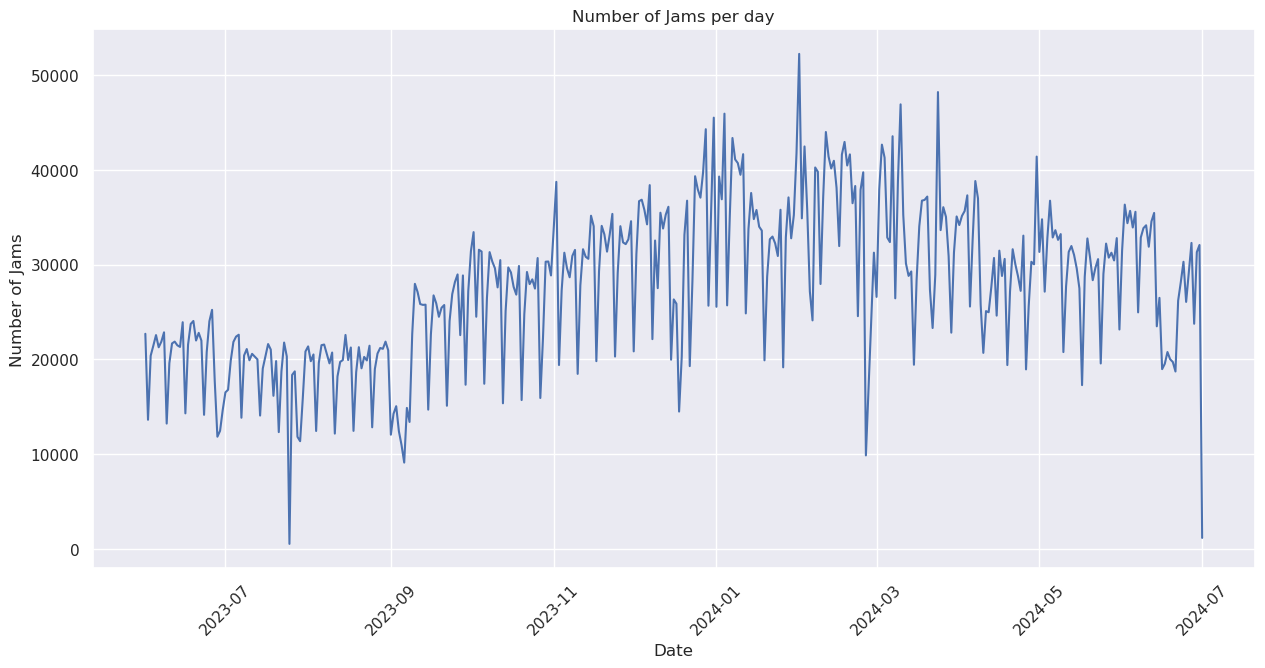

In [9]:
plots.jams_per_day(ddf)

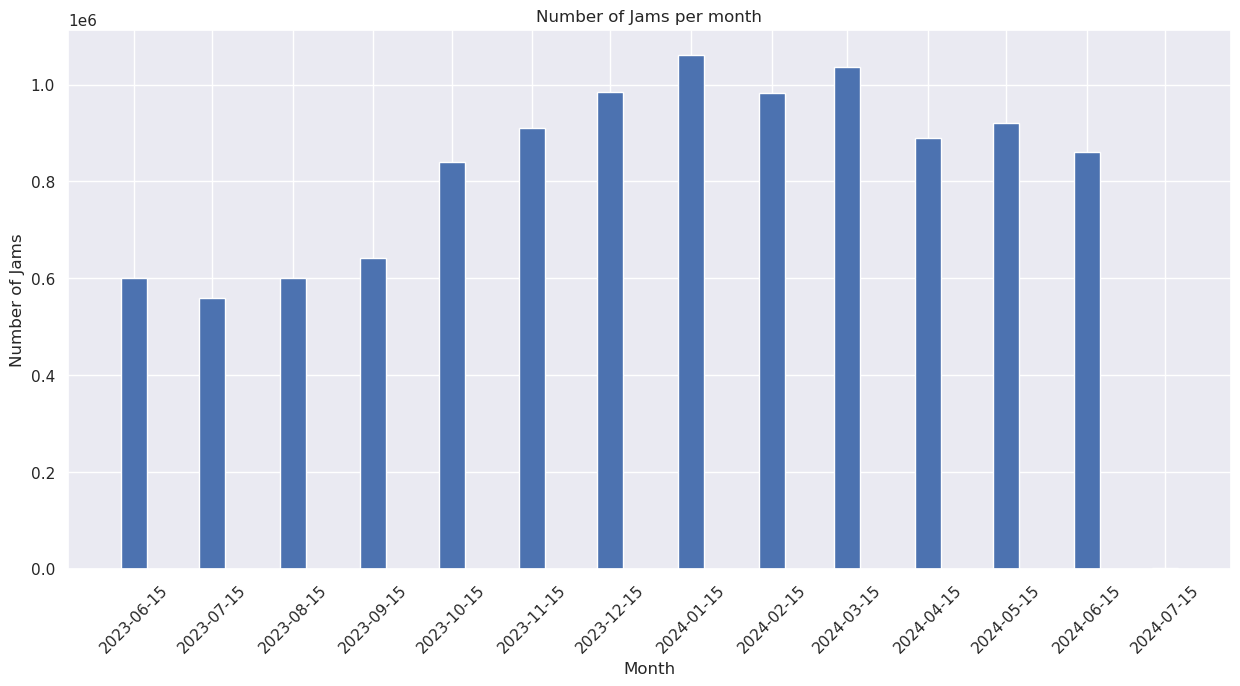

In [10]:
plots.jams_monthly_aggregated(ddf, save_fig = False)

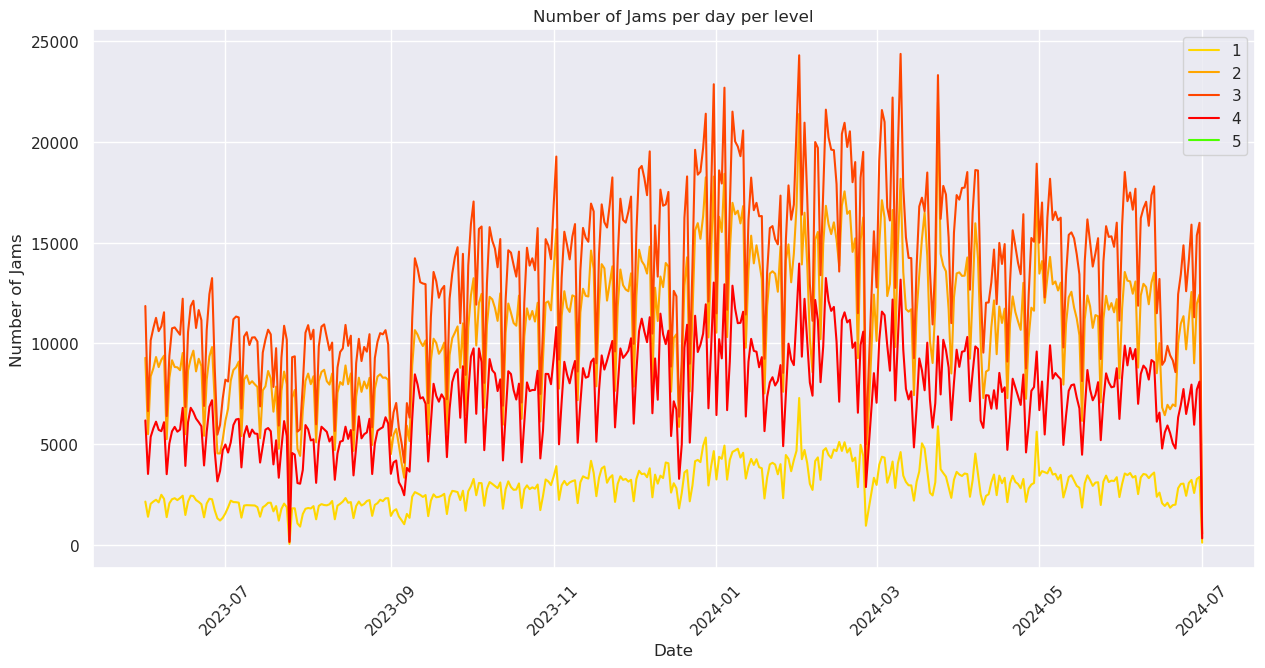

In [11]:
plots.jams_per_day_per_level(ddf, save_fig = False)

## Traffic Congestion Intensity
This index tries to not only consider the number of jams but its duration. Every time a jam appears in the waze dataset, we add its length, the more time a jam is seen, the more it contributes to the index. 
For now, this is done for the whole area of operation. 

If this indicator is useful, we can explore weighting it by the reduction in speed, or disaggregate it by level as well. 

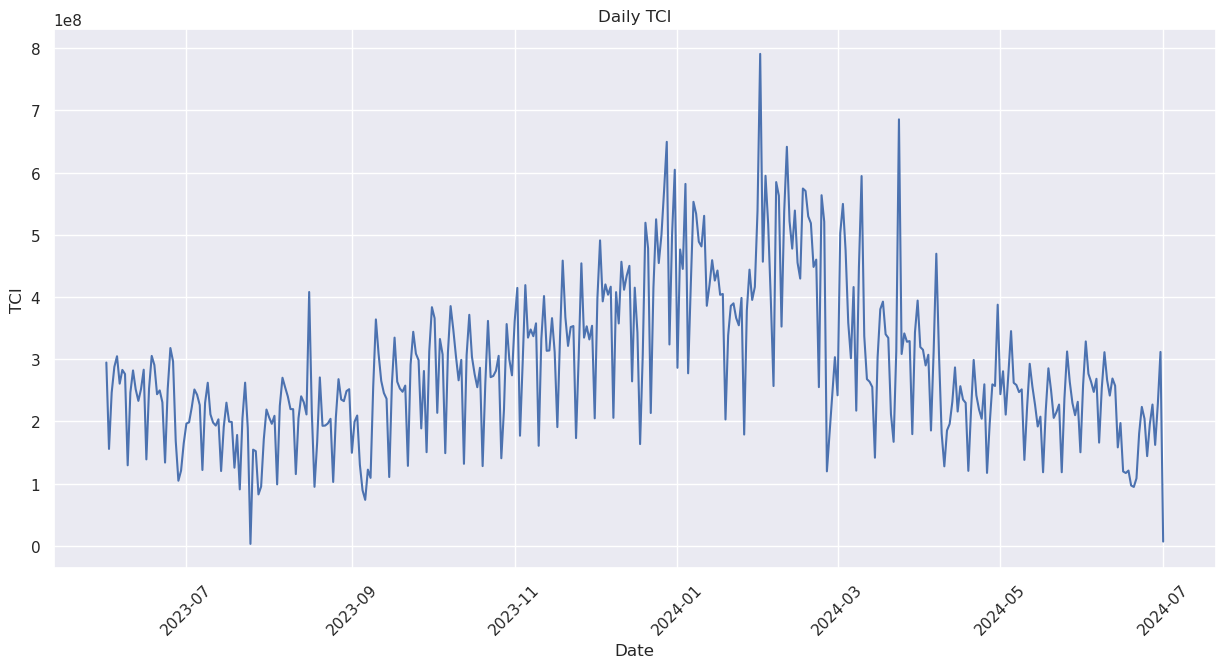

In [9]:
plots.regional_tci_per_day(ddf, save_fig = False)

### Hourly TCI by group of days
We grouped days considering working schema from Iraq (for client to confirm) Mon-Tue-Wed, Fri-Sat, Thu-Sun.
There is an important limitation that we only know when the jam starts but not when it ends.
Working days Mon-Tue-Wed: We generally observe the AM/PM peak. Morning peak is not that intense. For some months there are even 3 peaks or even a plateu between the morning and evening peak. Also, the PM peak is rather late, around 20.00 (Brainstorm with the client)
Weekends: We observe an evening peak around 20.00 (brainstorm with the client)

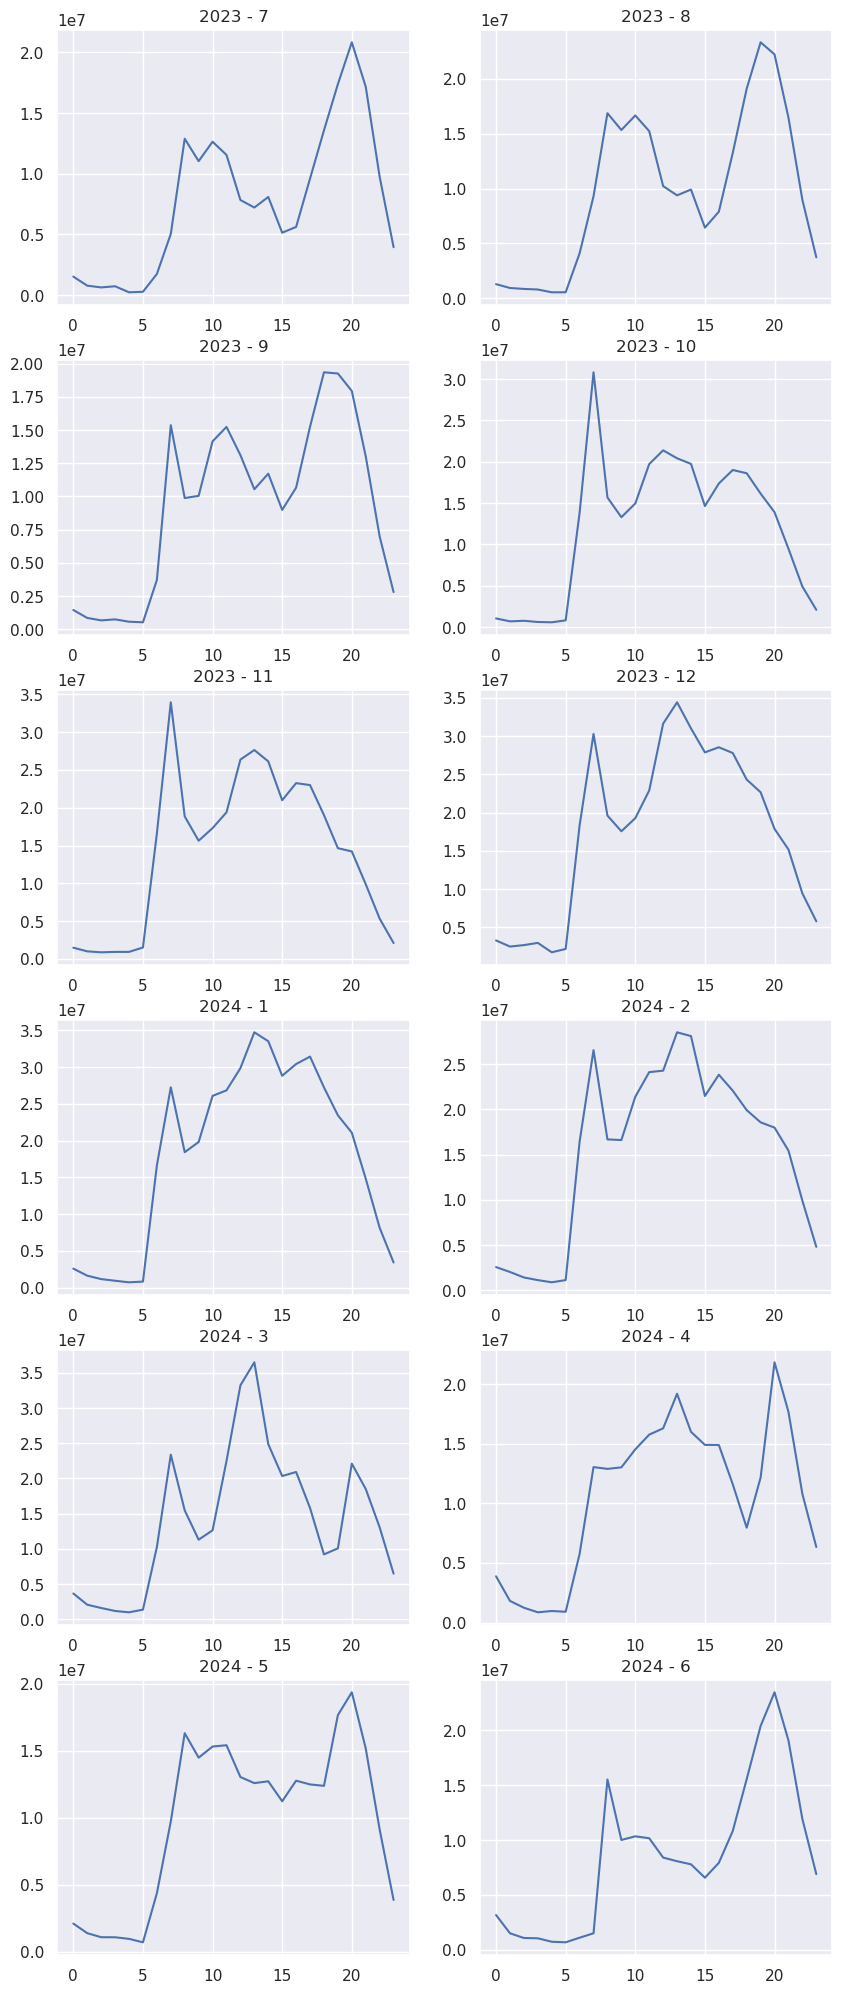

In [10]:
combination_year_month = [(2023, 7), (2023, 8), (2023, 9), (2023, 10), (2023, 11), (2023, 12), 
                          (2024, 1), (2024, 2), (2024, 3), (2024, 4), (2024, 5), (2024, 6)]
plots.hourly_tci_by_month (ddf, date_start='2023-06-01', date_end='2024-06-30', combination_year_month = combination_year_month, save_fig = False, group = 'Mon-Tues-Wed')

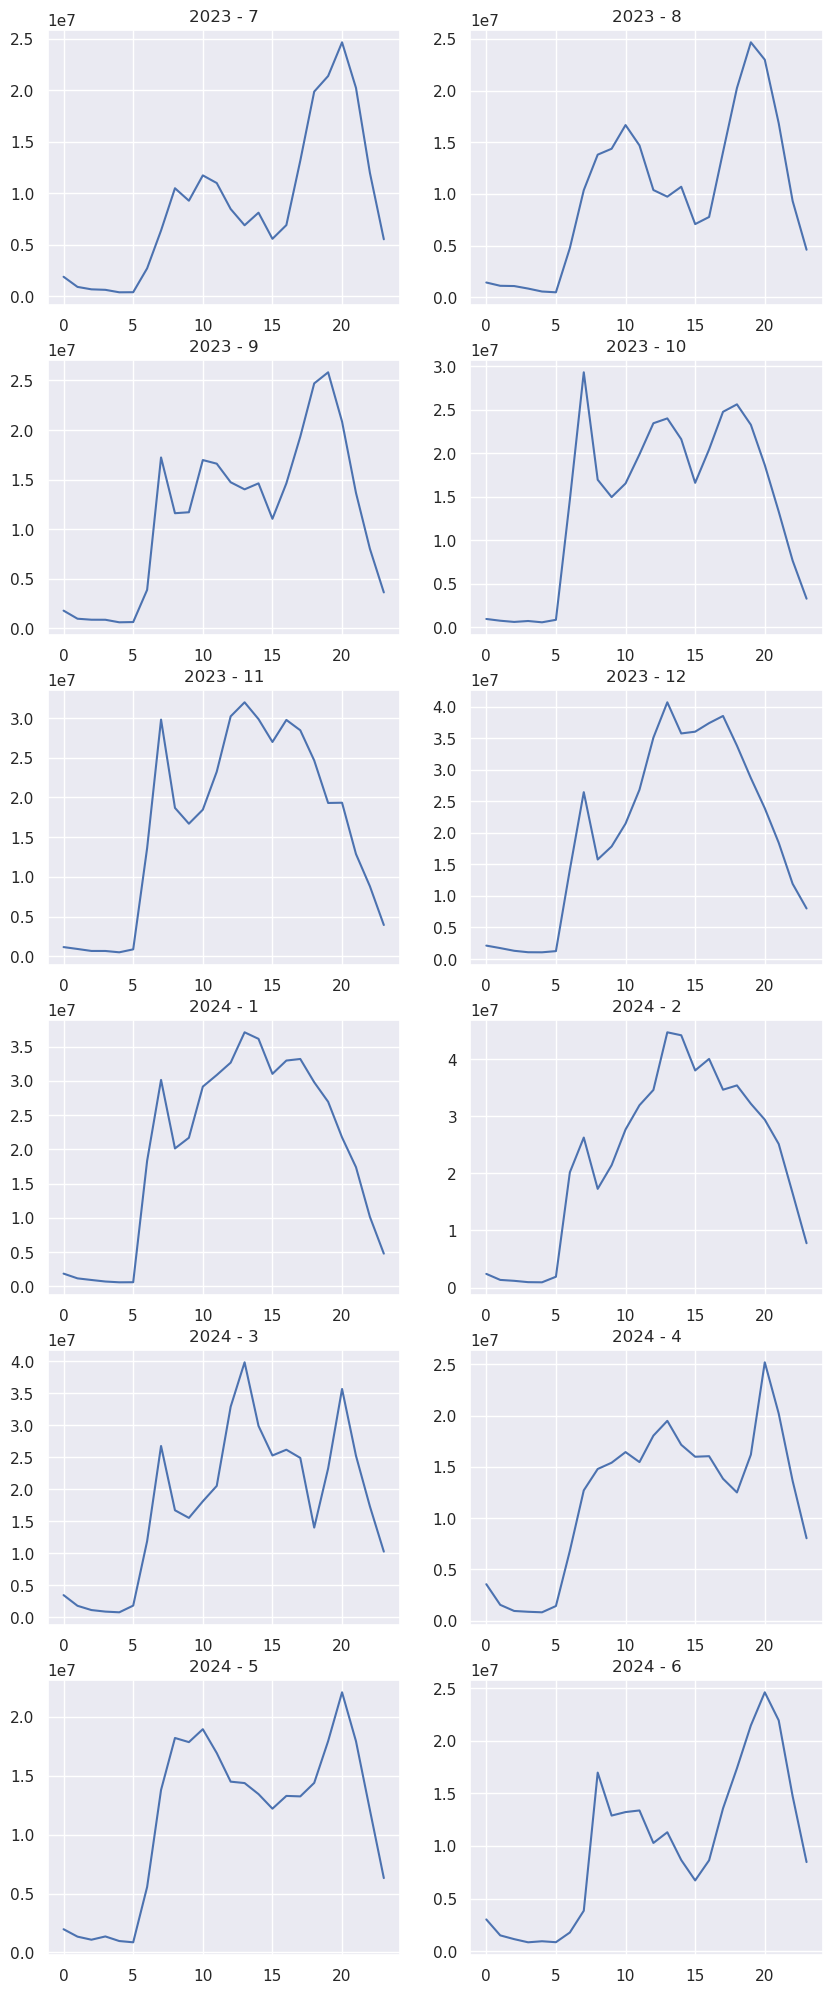

In [11]:
combination_year_month = [(2023, 7), (2023, 8), (2023, 9), (2023, 10), (2023, 11), (2023, 12), 
                          (2024, 1), (2024, 2), (2024, 3), (2024, 4), (2024, 5), (2024, 6)]
plots.hourly_tci_by_month (ddf, date_start='2023-06-01', date_end='2024-06-30', combination_year_month = combination_year_month, save_fig = False, group = 'Sun-Thu')

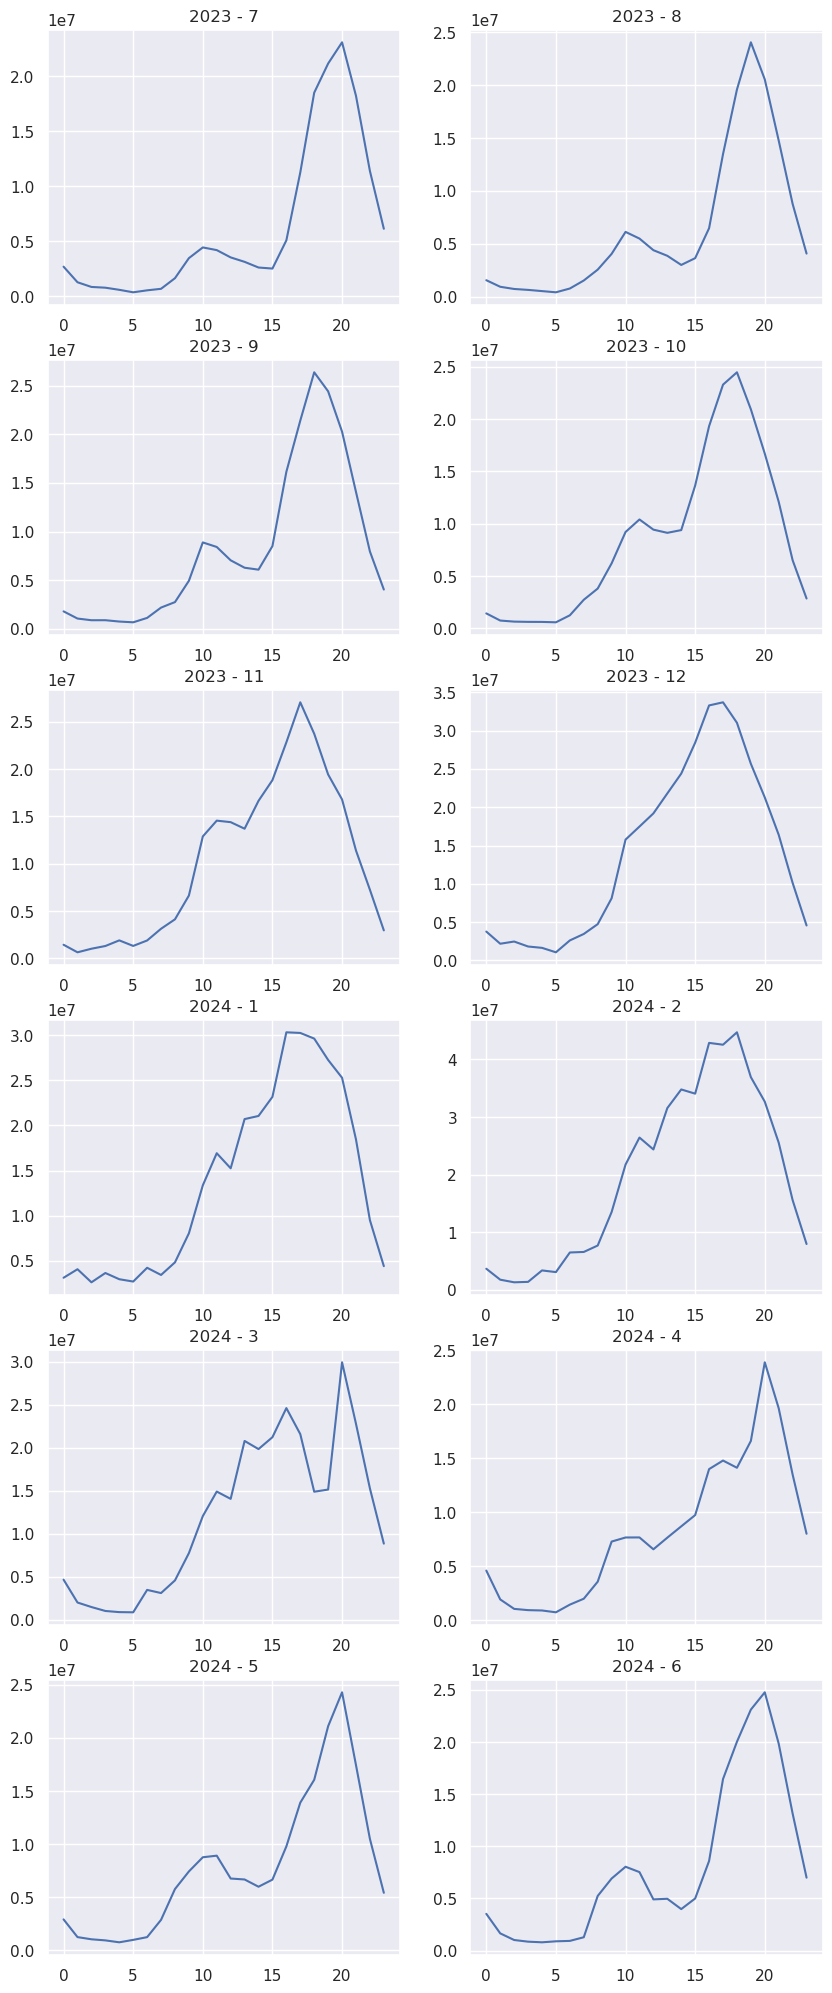

In [12]:
combination_year_month = [(2023, 7), (2023, 8), (2023, 9), (2023, 10), (2023, 11), (2023, 12), 
                          (2024, 1), (2024, 2), (2024, 3), (2024, 4), (2024, 5), (2024, 6)]
plots.hourly_tci_by_month (ddf, date_start='2023-06-01', date_end='2024-06-30', combination_year_month = combination_year_month, save_fig = False, group = 'Fri-Sat')

### TCI maps by group of days

In [7]:
start_date = datetime(2024, 5, 1)
end_date = datetime(2024, 5, 31)
path = 's3://wbg-waze/bq/IQ/595baghdad/jams/*.parquet'
ddf = dd.read_parquet(path, storage_options = storage_options, engine = 'pyarrow', filters = [('ts', '>=', start_date), ('ts', '<=', end_date)])

In [8]:
utils.handle_time(ddf, 'Asia/Baghdad', parquet = True)
ddf = utils.remove_level5(ddf)

In [9]:
gdf = utils.create_gdf(ddf)

In [10]:
#Area of Operation for Baghdad
bg = Polygon([(33.04781, 44.162516), (33.525369, 44.162516), (33.525369, 44.783304), (33.04781, 44.783304), (33.04781, 44.162516)])

In [11]:
hex_gdf = utils.obtain_hexagons_for_area(bg, 8)

In [12]:
jam_over_h3 = utils.parallelized_overlay(gdf, hex_gdf, ['date'])

In [13]:
jam_over_h3['length_in_polygon'] = jam_over_h3['geometry'].apply(lambda x: x.length)

In [14]:
hex_gdf.set_index('hex_id', inplace = True)

In [15]:
groups = {0: 'Mon-Tues-Wed',
          1: 'Mon-Tues-Wed',
          2: 'Mon-Tues-Wed',
          3: 'Sun-Thu',
          4: 'Fri-Sat',
          5: 'Fri-Sat',
          6: 'Sun-Thu'}
dates = pd.Series(pd.date_range(start_date, end_date)).reset_index()
dates.rename(columns = {0: 'date'}, inplace = True)
dates['dow'] = dates['date'].apply(lambda x: x.weekday())
dates['group'] = dates['dow'].map(groups)

In [16]:
for group in set(groups.values()):
    working_days = dates[dates['group']== group]['date'].tolist()
    hex_gdf[f'TCI_{group}'] = utils.mean_tci_geog(jam_over_h3, ['date'], ['hex_id'], 'length_in_polygon', working_days)

In [17]:
hex_gdf[hex_gdf['TCI_Mon-Tues-Wed']>0][['TCI_Mon-Tues-Wed', 'geometry']].explore(column = 'TCI_Mon-Tues-Wed', cmap = 'Spectral_r')

In [18]:
hex_gdf[hex_gdf['TCI_Fri-Sat']>0][['TCI_Fri-Sat', 'geometry']].explore(column = 'TCI_Fri-Sat', cmap = 'Spectral_r')

In [19]:
hex_gdf[hex_gdf['TCI_Sun-Thu']>0][['TCI_Sun-Thu', 'geometry']].explore(column = 'TCI_Sun-Thu', cmap = 'Spectral_r')

In [29]:
hex_gdf['geoWKT'] = hex_gdf['geometry'].apply(lambda x: wkt.dumps(x))

In [30]:
hex_gdf.drop('geometry', axis = 1).to_csv('tci_on_h3_may2024.csv')